# EraEx — Comprehensive EDA

**Dataset:** `data/EraEx_Dataset_Final.csv` — 779,938 tracks × 16 columns

**Columns:**
| Column | Type | Description |
|---|---|---|
| Track ID | string | YouTube video ID (11 chars) |
| Track Title | string | Song name |
| Artist Name | string | Artist |
| Album Title | string | Album |
| Release Year | int | 2010–2024 |
| Deezer Tags | string (list) | Genre/mood tags |
| Play Count | int | Total plays |
| Duration (s) | int | Song length in seconds |
| Explicit | bool | Explicit content flag |
| Deezer Fans | int | Deezer fan count |
| Deezer Rank | int | Chart rank |
| tempo | float | Audio tempo score |
| energy | float | Audio energy score |
| brightness | float | Audio brightness score |
| mood | float | Audio mood score  |
| valence | float | Audio positivity score |


---
## 1. Setup & Load

In [2]:
import pandas as pd
import numpy as np
import json, ast, os, warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.size'] = 11
PALETTE = 'husl'

# ── Path resolution: works from project root OR notebooks/ ──
CSV = 'data/EraEx_Dataset_Final.csv'
if not os.path.exists(CSV):
    CSV = '../data/EraEx_Dataset_Final.csv'
print(f'CSV path : {os.path.abspath(CSV)}')
print(f'Exists   : {os.path.exists(CSV)}')

CSV path : c:\Users\atuls\Documents\Team4_CPSC-5830-01-Capstone-Project\data\EraEx_Dataset_Final.csv
Exists   : True


In [3]:
print('Loading...')
df = pd.read_csv(CSV)
print(f'Loaded {len(df):,} rows × {df.shape[1]} columns')
df.head(3)

Loading...
Loaded 779,938 rows × 16 columns


,Track ID,Track Title,Artist Name,Album Title,Release Year,Deezer Tags,Play Count,Duration (s),Explicit,Deezer Fans,Deezer Rank,tempo,energy,brightness,mood,valence
0,lp-EO5I60KA,Thinking out Loud,Ed Sheeran,x (10th Anniversary Edition),2024,"[""soul"", ""love"", ""lovesong"", ""10s""]",4700000000,282,False,1219527,10648267,0.629852,0.495126,0.594836,0.697952,0.678505
1,nSDgHBxUbVQ,Photograph,Ed Sheeran,x (10th Anniversary Edition),2024,"[""pop"", ""emotional"", ""my song""]",3900000000,259,False,1209277,11519066,0.514152,0.571923,0.822745,0.291928,0.555047
2,34Na4j8AVgA,Starboy (feat. Daft Punk),The Weeknd,The Highlights (Deluxe),2024,"[""rnb"", ""soul"", ""canadian"", ""trap""]",3800000000,231,True,216793,1794882,0.567296,0.698825,0.392034,0.617414,0.420100


---
## 2. Dataset Overview

In [4]:
print('='*55)
print(f'  Rows      : {len(df):>10,}')
print(f'  Columns   : {df.shape[1]:>10}')
print(f'  Mem usage : {df.memory_usage(deep=True).sum()/1e6:>9.1f} MB')
print('='*55)
print('\nColumn Info:')
print(f'  {"Column":<22} {"Dtype":<12} {"Unique":>10}  {"NaN":>8}')
print('  ' + '-'*55)
for col in df.columns:
    print(f'  {col:<22} {str(df[col].dtype):<12} {df[col].nunique():>10,}  {df[col].isnull().sum():>8,}')
print()
print('Numeric summary:')
df.describe().round(3)

  Rows      :    779,938
  Columns   :         16
  Mem usage :     373.3 MB

Column Info:
  Column                 Dtype            Unique       NaN
  -------------------------------------------------------
  Track ID               object          779,938         0
  Track Title            object          569,876         0
  Artist Name            object           45,354         0
  Album Title            object           99,414         0
  Release Year           int64                15         0
  Deezer Tags            object              688         0
  Play Count             int64             7,942         0
  Duration (s)           int64             2,901         0
  Explicit               bool                  2         0
  Deezer Fans            int64           344,593         0
  Deezer Rank            int64           491,234         0
  tempo                  float64         779,416         0
  energy                 float64         779,414         0
  brightness             

,Release Year,Play Count,Duration (s),Deezer Fans,Deezer Rank,tempo,energy,brightness,mood,valence
count,779938.000,7.799380e+05,779938.000,7.799380e+05,7.799380e+05,779938.000,779938.000,779938.000,779938.000,779938.000
mean,2019.092,6.434833e+06,233.808,2.296617e+07,1.691001e+09,0.568,0.602,0.497,0.497,0.544
std,4.168,8.617499e+07,246.952,3.282393e+09,3.711161e+11,0.091,0.099,0.154,0.154,0.084
min,2010.000,1.000000e+00,1.000,0.000000e+00,0.000000e+00,-0.093,-0.058,0.000,0.000,0.083
25%,2016.000,4.740000e+02,162.000,2.145000e+03,9.752000e+03,0.526,0.559,0.397,0.396,0.488
50%,2020.000,9.700000e+03,210.000,2.920550e+04,1.967460e+05,0.575,0.615,0.499,0.499,0.555
75%,2023.000,1.690000e+05,263.000,3.268260e+05,3.078472e+06,0.622,0.665,0.601,0.600,0.604
max,2024.000,1.000000e+10,32401.000,1.847409e+12,2.254100e+14,0.950,0.936,1.000,1.000,0.915


---
## 3. Missing Values & Data Quality

In [5]:
# ── Missing values ──
miss = df.isnull().sum()
print('Missing values per column:')
print(miss.to_frame('count').assign(pct=(miss/len(df)*100).round(3)))

print(f'\nDuplicate rows        : {df.duplicated().sum():,}')
print(f'Duplicate Track IDs   : {df["Track ID"].duplicated().sum():,}')
print(f'Unique Track IDs      : {df["Track ID"].nunique():,}')

Missing values per column:
              count  pct
Track ID          0  0.0
Track Title       0  0.0
Artist Name       0  0.0
Album Title       0  0.0
Release Year      0  0.0
Deezer Tags       0  0.0
Play Count        0  0.0
Duration (s)      0  0.0
Explicit          0  0.0
Deezer Fans       0  0.0
Deezer Rank       0  0.0
tempo             0  0.0
energy            0  0.0
brightness        0  0.0
mood              0  0.0
valence           0  0.0

Duplicate rows        : 0
Duplicate Track IDs   : 0
Unique Track IDs      : 779,938


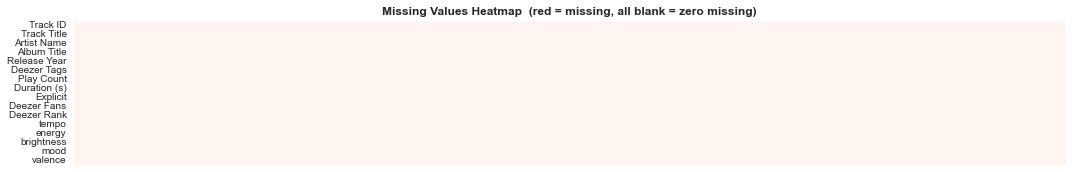

In [6]:
fig, ax = plt.subplots(figsize=(15, 2.5))
sns.heatmap(df.isnull().T, cbar=False, yticklabels=df.columns,
            xticklabels=False, cmap='Reds', ax=ax)
ax.set_title('Missing Values Heatmap  (red = missing, all blank = zero missing)', fontweight='bold')
plt.tight_layout()
plt.show()

---
## 4. Audio Features — Distributions:
- **tempo** — perceived speed  
- **energy** — intensity / loudness  
- **brightness** — high-frequency content  
- **mood** — overall emotional tone  
- **valence** — positivity / happiness

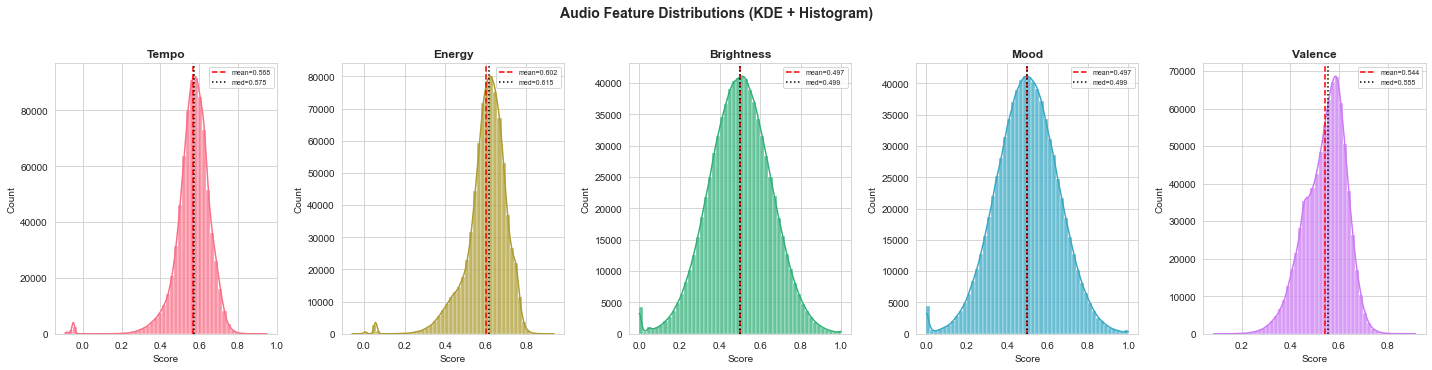

In [7]:
AUDIO = ['tempo', 'energy', 'brightness', 'mood', 'valence']
colors = sns.color_palette(PALETTE, 5)

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for ax, col, c in zip(axes, AUDIO, colors):
    data = df[col].dropna()
    sns.histplot(data, bins=50, kde=True, ax=ax, color=c, alpha=0.75)
    ax.axvline(data.mean(),   color='red',    ls='--', lw=1.5, label=f'mean={data.mean():.3f}')
    ax.axvline(data.median(), color='black',  ls=':',  lw=1.5, label=f'med={data.median():.3f}')
    ax.set_title(col.capitalize(), fontweight='bold')
    ax.set_xlabel('Score')
    ax.legend(fontsize=7)
plt.suptitle('Audio Feature Distributions (KDE + Histogram)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [8]:
print('Audio Features — Descriptive Statistics:')
df[AUDIO].describe().round(4)

Audio Features — Descriptive Statistics:


,tempo,energy,brightness,mood,valence
count,779938.0000,779938.0000,779938.0000,779938.0000,779938.0000
mean,0.5678,0.6021,0.4972,0.4970,0.5441
std,0.0906,0.0988,0.1539,0.1541,0.0839
min,-0.0933,-0.0584,0.0000,0.0000,0.0834
25%,0.5264,0.5588,0.3966,0.3965,0.4883
50%,0.5751,0.6145,0.4990,0.4986,0.5553
75%,0.6219,0.6651,0.6006,0.6002,0.6040
max,0.9501,0.9359,1.0000,1.0000,0.9148


---
## 5. Audio Features — Boxplot & Violin

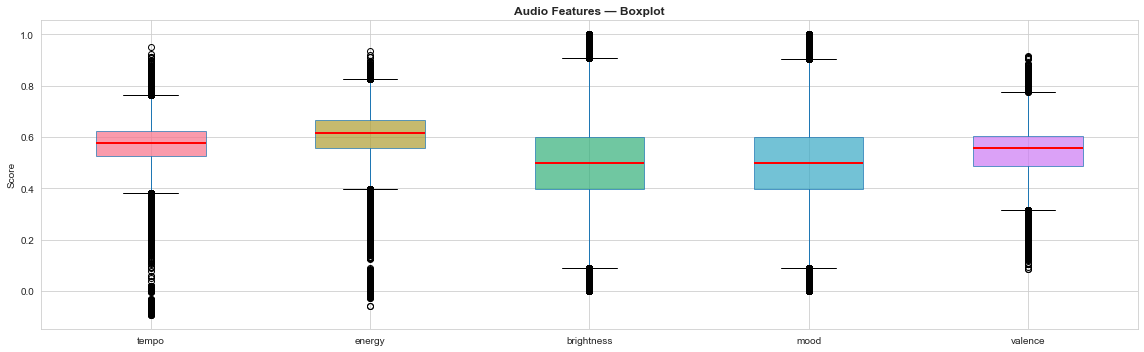

In [9]:
fig, axes = plt.subplots(figsize=(16, 5))

# Boxplot
bp = df[AUDIO].boxplot(ax=axes, patch_artist=True, return_type='dict',
                        medianprops=dict(color='red', linewidth=2))
colors_box = sns.color_palette(PALETTE, 5)
for patch, c in zip(bp['boxes'], colors_box):
    patch.set_facecolor(c)
    patch.set_alpha(0.7)
axes.set_title('Audio Features — Boxplot', fontweight='bold')
axes.set_ylabel('Score')


plt.tight_layout()
plt.show()

---
## 6. Correlation Analysis

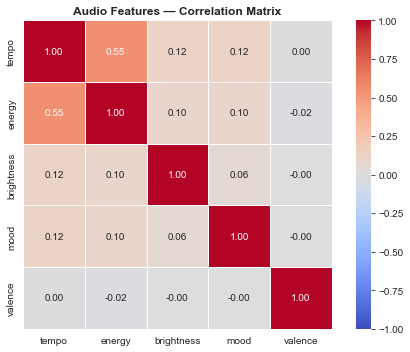

Top correlations:
tempo       energy        0.550
            mood          0.121
brightness  tempo         0.120
energy      mood          0.098
            brightness    0.097
brightness  mood          0.055
energy      valence      -0.017
valence     tempo         0.003
            brightness   -0.002
mood        valence      -0.002
dtype: float64


In [10]:
fig, ax = plt.subplots(figsize=(7, 5))
corr = df[AUDIO].corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm',
            vmin=-1, vmax=1, center=0, square=True,
            linewidths=0.5, ax=ax)
ax.set_title('Audio Features — Correlation Matrix', fontweight='bold')
plt.tight_layout()
plt.show()

# Strongest pairs
pairs = corr.unstack().sort_values(key=abs, ascending=False)
pairs = pairs[pairs.index.get_level_values(0) != pairs.index.get_level_values(1)].drop_duplicates()
print('Top correlations:')
print(pairs.head(10).round(3))

---
## 7. Popularity Analysis

In [11]:
POP = ['Play Count', 'Deezer Fans', 'Deezer Rank']
POP = [c for c in POP if c in df.columns]

print('Popularity columns — raw stats:')
df[POP].describe().applymap(lambda x: f'{x:,.0f}')

Popularity columns — raw stats:


,Play Count,Deezer Fans,Deezer Rank
count,"779,938","779,938","779,938"
mean,"6,434,833","22,966,175","1,691,000,597"
std,"86,174,987","3,282,393,129","371,116,143,065"
min,1,0,0
25%,474,"2,145","9,752"
50%,"9,700","29,206","196,746"
75%,"169,000","326,826","3,078,472"
max,"10,000,000,000","1,847,408,788,253","225,410,023,841,722"


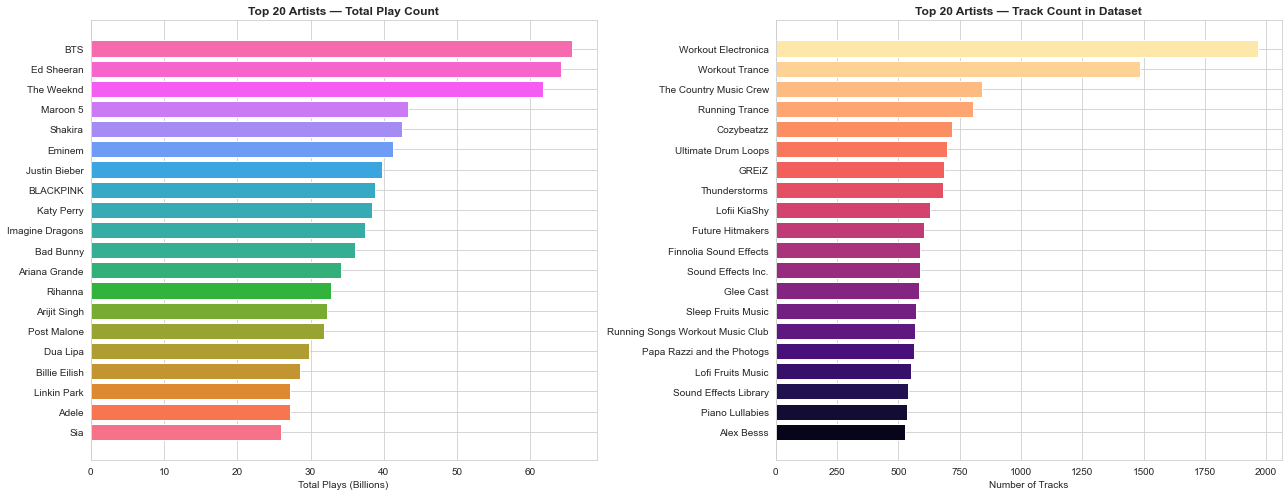

In [12]:
# Top 20 artists — by total play count
art_play = (
    df.groupby('Artist Name')['Play Count']
    .sum().sort_values(ascending=False).head(20)
)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

axes[0].barh(art_play.index[::-1], art_play.values[::-1] / 1e9,
             color=sns.color_palette(PALETTE, 20))
axes[0].set_title('Top 20 Artists — Total Play Count', fontweight='bold')
axes[0].set_xlabel('Total Plays (Billions)')

# Top 20 artists — by track count in dataset
art_cnt = df['Artist Name'].value_counts().head(20)
axes[1].barh(art_cnt.index[::-1], art_cnt.values[::-1],
             color=sns.color_palette('magma', 20))
axes[1].set_title('Top 20 Artists — Track Count in Dataset', fontweight='bold')
axes[1].set_xlabel('Number of Tracks')

plt.tight_layout()
plt.show()

---
## 8. Release Year Analysis

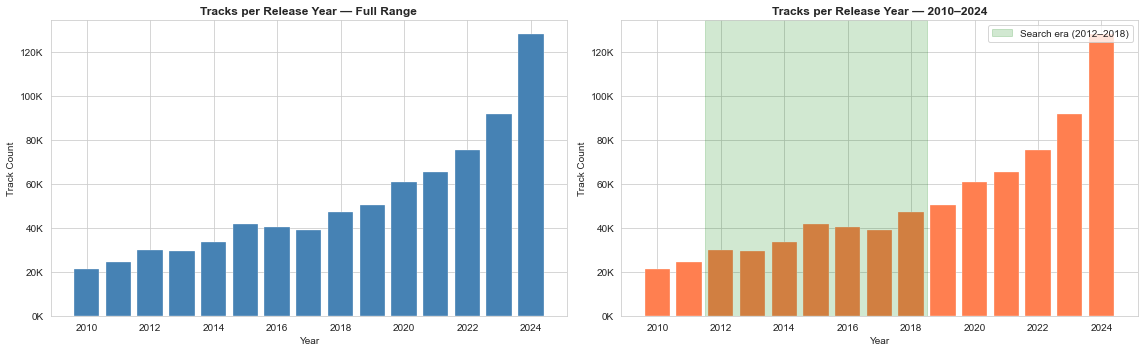

In [13]:
year = df['Release Year'].dropna().astype(int)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# All years
vc = year.value_counts().sort_index()
axes[0].bar(vc.index, vc.values, color='steelblue', edgecolor='white', linewidth=0.3)
axes[0].set_title('Tracks per Release Year — Full Range', fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Track Count')
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x/1e3)}K'))

# 2010–2024 zoomed with search era shading
era = year[(year >= 2010) & (year <= 2024)]
vc2 = era.value_counts().sort_index()
axes[1].bar(vc2.index, vc2.values, color='coral', edgecolor='white', linewidth=0.3)
axes[1].axvspan(2011.5, 2018.5, alpha=0.18, color='green', label='Search era (2012–2018)')
axes[1].set_title('Tracks per Release Year — 2010–2024', fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Track Count')
axes[1].legend()
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x/1e3)}K'))

plt.tight_layout()
plt.show()

---
## 9. Audio Features Trend Over Years

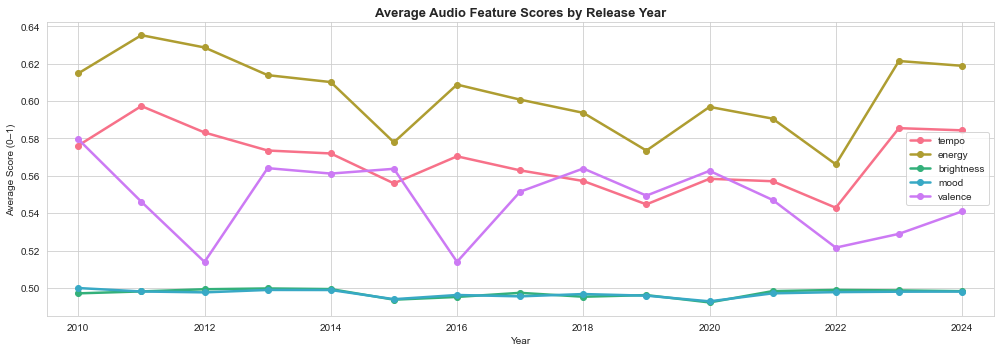

In [14]:
era_df = df[df['Release Year'].between(2010, 2024)]
ya = era_df.groupby('Release Year')[AUDIO].mean().reset_index()

fig, ax = plt.subplots(figsize=(14, 5))
for col, c in zip(AUDIO, sns.color_palette(PALETTE, 5)):
    ax.plot(ya['Release Year'], ya[col], marker='o', linewidth=2.5,
            color=c, label=col)

ax.set_title('Average Audio Feature Scores by Release Year', fontsize=13, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Average Score (0–1)')
ax.legend()
ax.set_xlim(2009.5, 2024.5)
plt.tight_layout()
plt.show()

---
## 10. Tag / Genre Analysis

In [15]:
def parse_tags(v):
    if isinstance(v, list): return v
    try:    return ast.literal_eval(str(v))
    except:
        try:    return json.loads(str(v))
        except: return []

print('Parsing tags...')
df['parsed_tags'] = df['Deezer Tags'].apply(parse_tags)
df['tag_count']   = df['parsed_tags'].apply(len)

all_tags  = [t.lower().strip() for tags in df['parsed_tags'] for t in tags if t]
tag_cnt   = Counter(all_tags)

print(f'Total tag occurrences : {len(all_tags):,}')
print(f'Unique tags           : {len(tag_cnt):,}')
print(f'Avg tags per song     : {df["tag_count"].mean():.2f}')
print(f'Max tags on one song  : {df["tag_count"].max()}')
print(f'Songs with 0 tags     : {(df["tag_count"]==0).sum():,}')
print()
print('Top 10 tags:')
for tag, cnt in tag_cnt.most_common(10):
    bar = '█' * int(cnt / max(tag_cnt.values()) * 10)
    print(f'  {tag:<22} {cnt:>8,}  {bar}')

Parsing tags...
Total tag occurrences : 2,824,221
Unique tags           : 430
Avg tags per song     : 3.62
Max tags on one song  : 5
Songs with 0 tags     : 0

Top 10 tags:
  pop                     292,746  ██████████
  indie                   162,061  █████
  dance                   138,030  ████
  alternative             130,051  ████
  soul                     89,615  ███
  folk                     86,162  ██
  electronic               82,322  ██
  indie folk               72,623  ██
  singer-songwriter        70,378  ██
  rnb                      66,822  ██


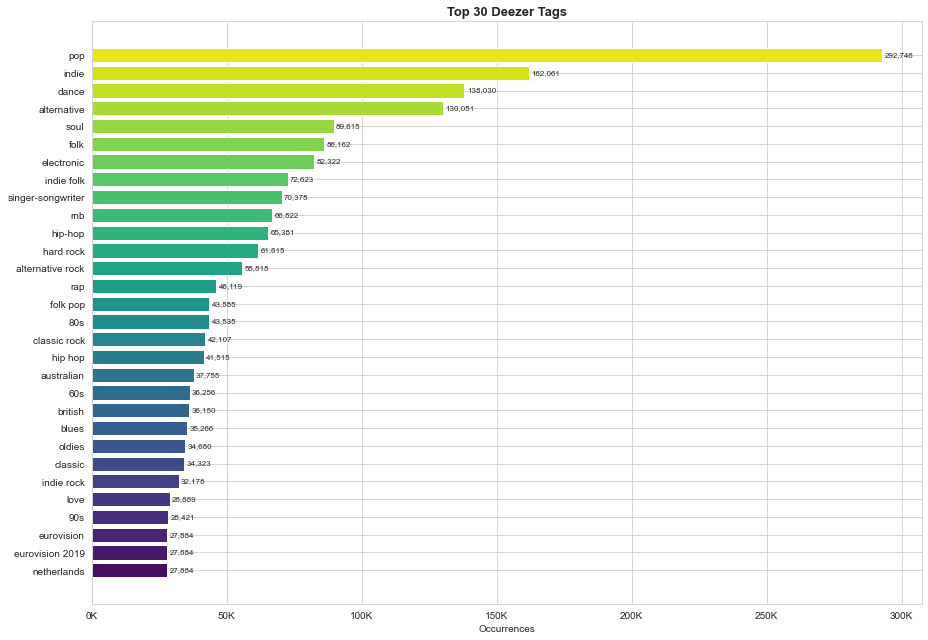

In [16]:
top_tags = pd.DataFrame(tag_cnt.most_common(30), columns=['Tag', 'Count'])

fig, ax = plt.subplots(figsize=(13, 9))
colors_t = sns.color_palette('viridis', 30)
bars = ax.barh(top_tags['Tag'][::-1], top_tags['Count'][::-1], color=colors_t)
for bar, cnt in zip(bars, top_tags['Count'][::-1]):
    ax.text(bar.get_width() + top_tags['Count'].max()*0.003,
            bar.get_y() + bar.get_height()/2,
            f'{cnt:,}', va='center', fontsize=8)
ax.set_title('Top 30 Deezer Tags', fontsize=13, fontweight='bold')
ax.set_xlabel('Occurrences')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x/1e3)}K'))
plt.tight_layout()
plt.show()

In [18]:
# Top tag per year (2012-2018 search era)
rows = []
for yr in range(2012, 2019):
    subset = df[df['Release Year'] == yr]
    tags_yr = [t.lower().strip() for tags in subset['parsed_tags'] for t in tags if t]
    top5 = Counter(tags_yr).most_common(1)
    for tag, cnt in top5:
        rows.append({'Year': yr, 'Tag': tag, 'Count': cnt})

tag_yr_df = pd.DataFrame(rows)
print('Top tag per year (search era 2012–2018):')
print(tag_yr_df.to_string(index=False))

Top tag per year (search era 2012–2018):
 Year         Tag  Count
 2012 alternative  14575
 2013         pop  20314
 2014         pop  23384
 2015         pop  24840
 2016         pop  12991
 2017         pop  22318
 2018         pop  29293


---
## 11. Explicit Content

Explicit value counts:
Explicit
False    689427
True      90511
Name: count, dtype: int64

Explicit     : 90,511  (11.6%)
Not Explicit : 689,427  (88.4%)


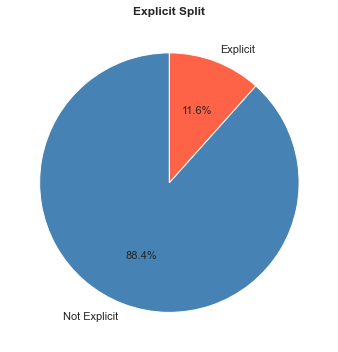

In [30]:
exp_vc = df['Explicit'].value_counts()
print('Explicit value counts:')
print(exp_vc)
print(f'\nExplicit     : {exp_vc.get(True, 0):,}  ({exp_vc.get(True, 0)/len(df)*100:.1f}%)')
print(f'Not Explicit : {exp_vc.get(False,0):,}  ({exp_vc.get(False,0)/len(df)*100:.1f}%)')

fig, axes = plt.subplots(1, 1, figsize=(18, 5))

# Pie
axes.pie([exp_vc.get(False,0), exp_vc.get(True,0)],
            labels=['Not Explicit', 'Explicit'],
            autopct='%1.1f%%',
            colors=['steelblue', 'tomato'],
            startangle=90, textprops={'fontsize': 11})
axes.set_title('Explicit Split', fontweight='bold')


plt.tight_layout()
plt.show()

---
## 12. Word Clouds

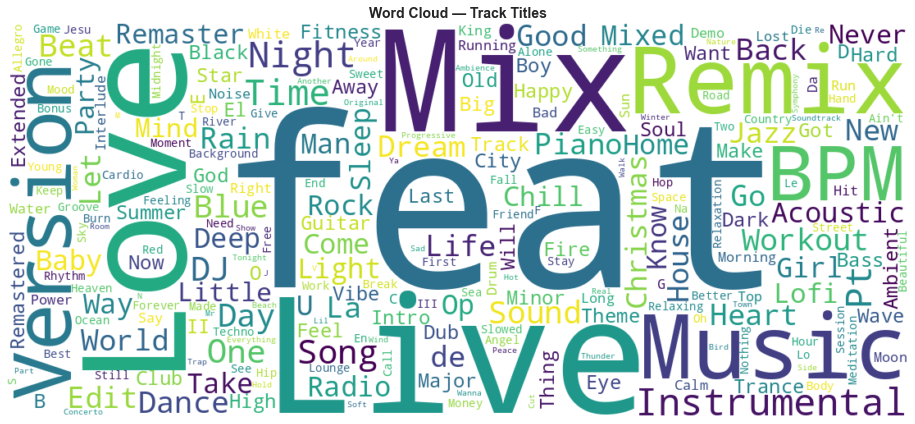

In [27]:
title_text = ' '.join(df['Track Title'].dropna().astype(str).tolist())
wc1 = WordCloud(width=1100, height=480, background_color='white',
                colormap='viridis', max_words=250,
                collocations=False).generate(title_text)

fig, ax = plt.subplots(figsize=(14, 6))
ax.imshow(wc1, interpolation='bilinear')
ax.axis('off')
ax.set_title('Word Cloud — Track Titles', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

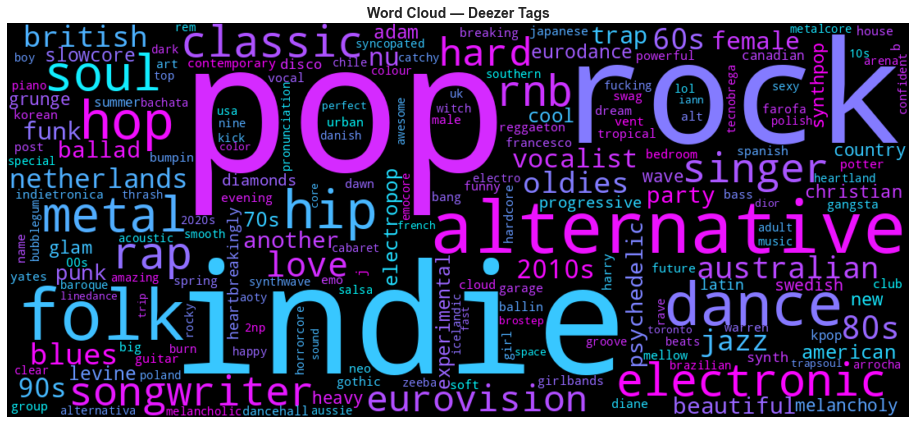

In [28]:
tag_text = ' '.join(all_tags)
wc2 = WordCloud(width=1100, height=480, background_color='black',
                colormap='cool', max_words=200,
                collocations=False).generate(tag_text)

fig, ax = plt.subplots(figsize=(14, 6))
ax.imshow(wc2, interpolation='bilinear')
ax.axis('off')
ax.set_title('Word Cloud — Deezer Tags', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

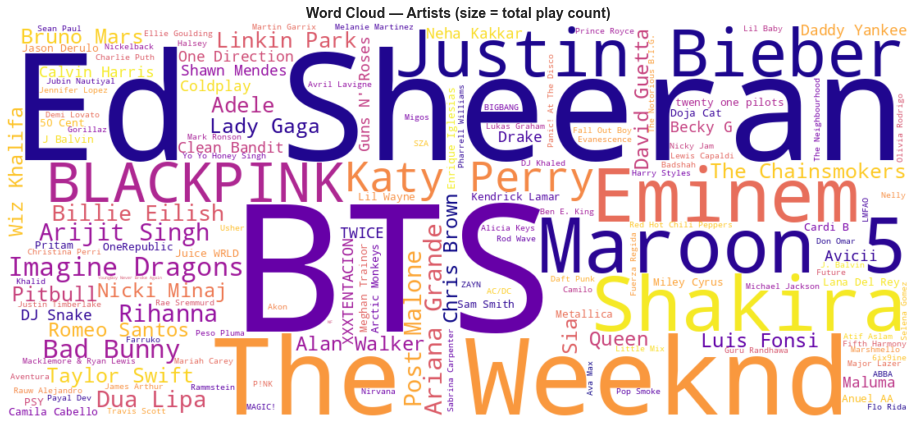

In [31]:
# Artist cloud — weighted by total play count
art_freq = df.groupby('Artist Name')['Play Count'].sum().to_dict()
wc3 = WordCloud(width=1100, height=480, background_color='white',
                colormap='plasma', max_words=150,
                collocations=False).generate_from_frequencies(art_freq)

fig, ax = plt.subplots(figsize=(14, 6))
ax.imshow(wc3, interpolation='bilinear')
ax.axis('off')
ax.set_title('Word Cloud — Artists (size = total play count)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()